In [1]:
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print(torch.cuda.is_available())

print("Using", device)

True
Using cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

X_test = np.load("/content/drive/MyDrive/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

X_train_valid = X_train_valid[:, :, :500]
X_test = X_test[:, :, :500]


# modify labels to be 0-3
y_train_valid -= 769
y_test -= 769


ind_valid = np.random.choice(2115, 300, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(X_train, X_val) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_val) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_val.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_val.shape)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).view(-1, 22, 500), torch.from_numpy(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).view(-1, 22, 500), torch.from_numpy(y_val))
X_test = torch.from_numpy(X_test).view(-1, 22, 500)
y_test = torch.from_numpy(y_test)

rand_order = np.random.permutation(np.arange(2115))
fold_ind_val = [rand_order[2115 * i // 5 : 2115 * (i + 1) // 5] for i in range(5)]
fold_ind_train = [list(set(range(2115)).difference(set(v_fold))) for v_fold in fold_ind_val]
fold_train_dataset = [torch.utils.data.TensorDataset(torch.from_numpy(X_train_valid[i]).view(-1, 22, 500), torch.from_numpy(y_train_valid[i])) for i in fold_ind_train]
fold_val_dataset = [torch.utils.data.TensorDataset(torch.from_numpy(X_train_valid[i]).view(-1, 22, 500), torch.from_numpy(y_train_valid[i])) for i in fold_ind_val]

Mounted at /content/drive
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
Shape of training set: (1815, 22, 500)
Shape of validation set: (300, 22, 500)
Shape of training labels: (1815,)
Shape of validation labels: (300,)


### Shape of data

In [4]:
class SmallConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, norm=False, dropout=False):
        super(SmallConvBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # conv -> relu -> (norm) -> pool -> dropout
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        if (self.norm):
            x = self.bn1(x)
        if (self.dropout):
            x = self.drop1(x)
        return x


class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, norm=False, dropout=False):
        super(DoubleConvBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # conv -> conv -> relu -> (norm) -> pool -> dropout
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        if (self.norm):
            x = self.bn1(x)
        if (self.dropout):
            x = self.drop1(x)
        return x

class TripleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, norm=False, dropout=False):
        super(TripleConvBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # conv -> conv -> relu -> (norm) -> pool -> dropout
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu3 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool1(x)
        if (self.norm):
            x = self.bn1(x)
        if (self.dropout):
            x = self.drop1(x)
        return x


class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()

        # start: 22 x 500
        self.cblock1 = SmallConvBlock(22, 128, 5, dropout=True, norm=True)
        self.cblock2 = SmallConvBlock(128, 256, 5, dropout=True, norm=False)
        self.cblock3 = SmallConvBlock(256, 512, 5, dropout=True, norm=False)
        self.cblock4 = SmallConvBlock(512, 1024, 5, dropout=True, norm=True)
        self.output = nn.Linear(1024 * 6, 4)


    def forward(self, x):
        x = self.cblock1(x)
        x = self.cblock2(x)
        x = self.cblock3(x)
        x = self.cblock4(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

# Single CNN


In [5]:
model = BasicCNN().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)


def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
model.apply(weights_init)

torch.Size([64, 4])


BasicCNN(
  (cblock1): SmallConvBlock(
    (conv1): Conv1d(22, 128, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock2): SmallConvBlock(
    (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock3): SmallConvBlock(
    (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [6]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

In [7]:
num_epochs = 100
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")


Epoch 1, Train loss: 2.463, Train acc: 0.280, Val loss: 1.668, Val acc: 0.270
Epoch 2, Train loss: 1.984, Train acc: 0.314, Val loss: 1.759, Val acc: 0.287
Epoch 3, Train loss: 1.868, Train acc: 0.325, Val loss: 2.379, Val acc: 0.250
Epoch 4, Train loss: 1.647, Train acc: 0.359, Val loss: 1.467, Val acc: 0.373
Epoch 5, Train loss: 1.639, Train acc: 0.360, Val loss: 1.335, Val acc: 0.360
Epoch 6, Train loss: 1.580, Train acc: 0.385, Val loss: 1.332, Val acc: 0.423
Epoch 7, Train loss: 1.403, Train acc: 0.414, Val loss: 1.203, Val acc: 0.480
Epoch 8, Train loss: 1.317, Train acc: 0.442, Val loss: 1.248, Val acc: 0.453
Epoch 9, Train loss: 1.254, Train acc: 0.474, Val loss: 1.201, Val acc: 0.513
Epoch 10, Train loss: 1.218, Train acc: 0.487, Val loss: 1.185, Val acc: 0.487
Epoch 11, Train loss: 1.183, Train acc: 0.506, Val loss: 1.048, Val acc: 0.583
Epoch 12, Train loss: 1.148, Train acc: 0.511, Val loss: 1.106, Val acc: 0.503
Epoch 13, Train loss: 1.077, Train acc: 0.557, Val loss: 1.15

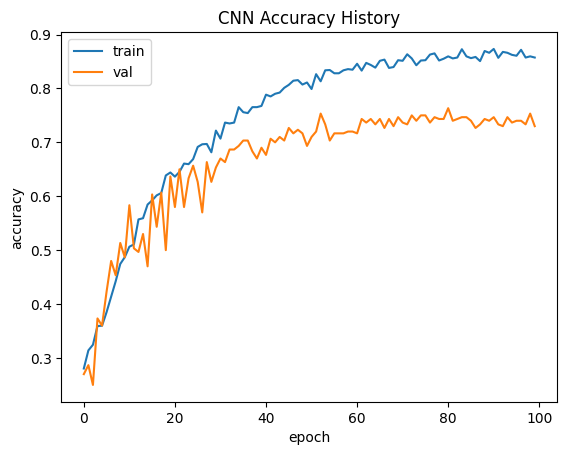

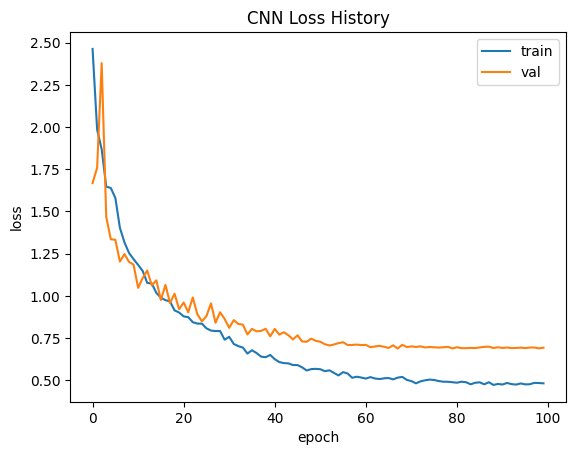

In [8]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [9]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.734, Test acc: 0.725


# Ensembled

In [10]:
models = []
train_loss_model_history = []
train_acc_model_history = []

for i in range(5):
    print(f"using validation fold {i}")
    model = BasicCNN().to(device)
    model.apply(weights_init)

    cel_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
    train_loader = torch.utils.data.DataLoader(fold_train_dataset[i], batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(fold_val_dataset[i], shuffle=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

    num_epochs = 100
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model.train()
        train_count = 0
        train_correct_count = 0
        train_loss = 0
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            logits = model(train_x)
            loss = cel_loss(logits, train_y)
            train_loss += loss
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_loss_history.append(train_loss/len(train_loader))
        train_acc_history.append(train_acc)

        model.eval()
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)
                logits = model(val_x).detach()
                loss = cel_loss(logits, val_y)
                val_loss += loss
                y_hat = torch.argmax(logits, dim=-1)
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_x.size(0)
            val_acc = val_correct_count / val_count
            val_loss_history.append(val_loss/len(val_loader))
            val_acc_history.append(val_acc)
        scheduler.step()


        print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")


    models.append(model)
    train_loss_model_history.append(train_loss_history)
    train_acc_model_history.append(train_acc_history)

using validation fold 0
Epoch 1, Train loss: 2.478, Train acc: 0.297, Val loss: 1.787, Val acc: 0.296
Epoch 2, Train loss: 1.949, Train acc: 0.330, Val loss: 1.557, Val acc: 0.293
Epoch 3, Train loss: 1.777, Train acc: 0.348, Val loss: 1.343, Val acc: 0.369
Epoch 4, Train loss: 1.648, Train acc: 0.381, Val loss: 1.290, Val acc: 0.430
Epoch 5, Train loss: 1.535, Train acc: 0.405, Val loss: 1.517, Val acc: 0.340
Epoch 6, Train loss: 1.352, Train acc: 0.438, Val loss: 1.113, Val acc: 0.501
Epoch 7, Train loss: 1.351, Train acc: 0.446, Val loss: 1.124, Val acc: 0.482
Epoch 8, Train loss: 1.253, Train acc: 0.512, Val loss: 1.273, Val acc: 0.449
Epoch 9, Train loss: 1.220, Train acc: 0.497, Val loss: 1.182, Val acc: 0.459
Epoch 10, Train loss: 1.123, Train acc: 0.537, Val loss: 1.103, Val acc: 0.527
Epoch 11, Train loss: 1.120, Train acc: 0.563, Val loss: 1.146, Val acc: 0.470
Epoch 12, Train loss: 1.061, Train acc: 0.569, Val loss: 1.102, Val acc: 0.511
Epoch 13, Train loss: 1.035, Train ac

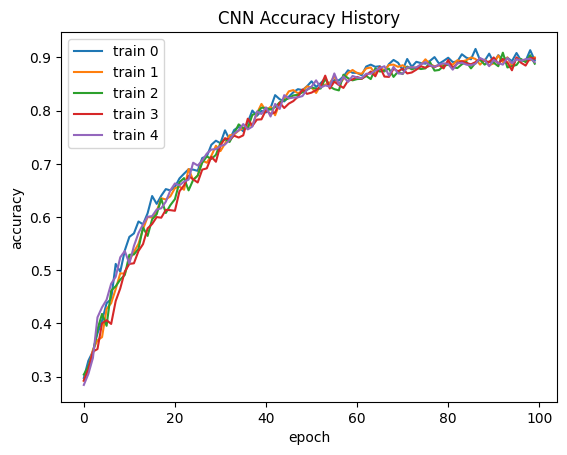

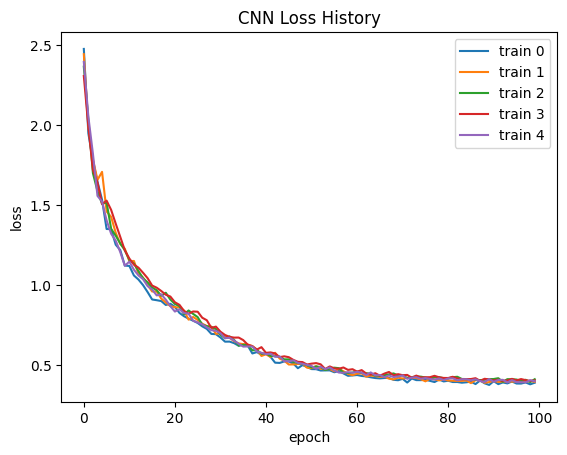

In [11]:
# Plotting accuracy trajectory
for i in range(5):
    train_acc_history = train_acc_model_history[i]
    train_acc_history_moved = [x.cpu() for x in train_acc_history]
    plt.plot(train_acc_history_moved, label=f"train {i}")
plt.title('CNN Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
for i in range(5):
    train_loss_history = train_loss_model_history[i]
    train_loss_history_conv = [x.item() for x in train_loss_history]
    plt.plot(train_loss_history_conv, label=f"train {i}")
plt.title('CNN Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [12]:
with torch.no_grad():
    logits = torch.stack([model(X_test) for model in models])
    logits = torch.mean(logits, dim=0)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Ensembled acc: {test_acc:.3f}")

Ensembled acc: 0.731
